# 과제 1: SVD로 이미지 압축 해보기
자신의 이미지를 SVD로 압축하고 k값에 따른 변화 관찰

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False
from PIL import Image

In [26]:
# 이미지 로드
img = np.array(Image.open('cat.jpg').convert('L'))

# SVD 분해
U, s, VT = np.linalg.svd(img, full_matrices=False)

print(f'원본 이미지 크기 : {img.shape}')
print(f'특잇값 개수 : {len(s)}')

원본 이미지 크기 : (640, 640)
특잇값 개수 : 640


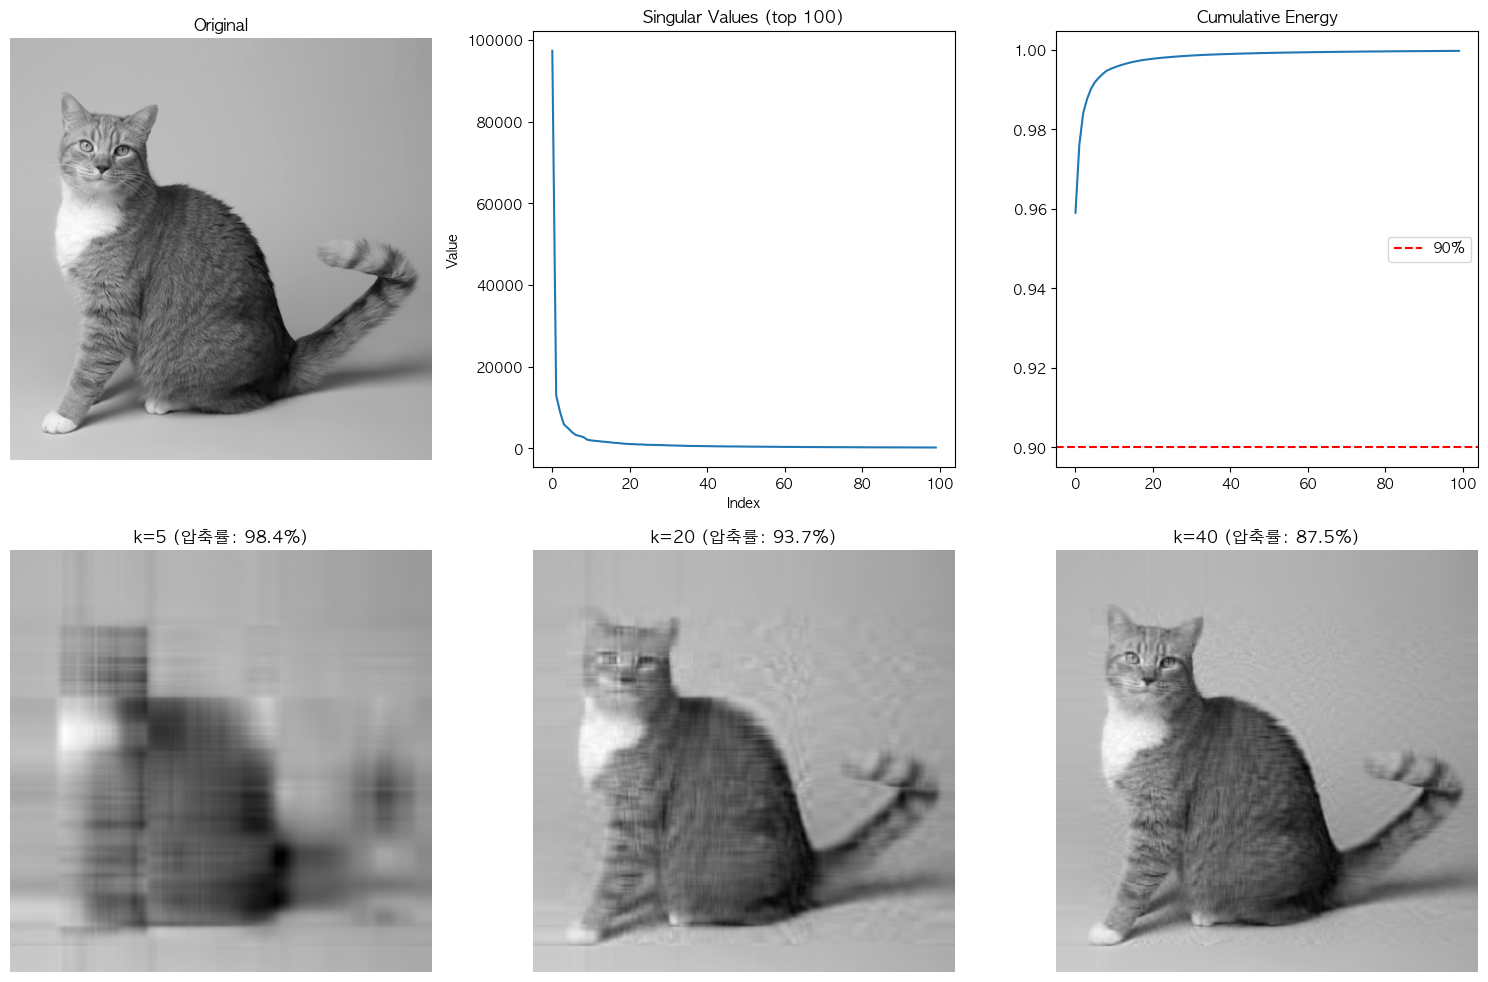

In [119]:
# 다양한 k 값으로 압축
k_values = [5, 20, 40]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 원본
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# 특잇값 그래프
axes[0, 1].plot(s[:100])
axes[0, 1].set_title('Singular Values (top 100)')
axes[0, 1].set_xlabel('Index')
axes[0, 1].set_ylabel('Value')

# 누적 에너지
cumsum = np.cumsum(s**2) / np.sum(s**2)
axes[0, 2].plot(cumsum[:100])
axes[0, 2].set_title('Cumulative Energy')
axes[0, 2].axhline(y=0.9, color='r', linestyle='--', label='90%')
axes[0, 2].legend()

# 압축된 이미지들
for idx, k in enumerate(k_values):
    # k개 특잇값으로 재구성
    img_compressed = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    
    # 압축률 계산
    original_size = img.shape[0] * img.shape[1]
    compressed_size = k * (img.shape[0] + img.shape[1] + 1)
    ratio = (1 - compressed_size / original_size) * 100
    
    # 시각화
    row = 1 + idx // 3
    col = idx % 3
    axes[row, col].imshow(img_compressed, cmap='gray')
    axes[row, col].set_title(f'k={k} (압축률: {ratio:.1f}%)')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [120]:
# 정보 보존률 계산
for k in k_values:
    energy = np.sum(s[:k]**2) / np.sum(s**2) * 100
    print(f"k={k}: 정보 보존률 {energy:.1f}%")

k=5: 정보 보존률 99.0%
k=20: 정보 보존률 99.8%
k=40: 정보 보존률 99.9%


---
# 과제 2: 파라미터 실험  
eps와 min_samples 조정하기  
→ 최적 선택 및 결과 비교

In [121]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons, make_circles
from sklearn.neighbors import NearestNeighbors

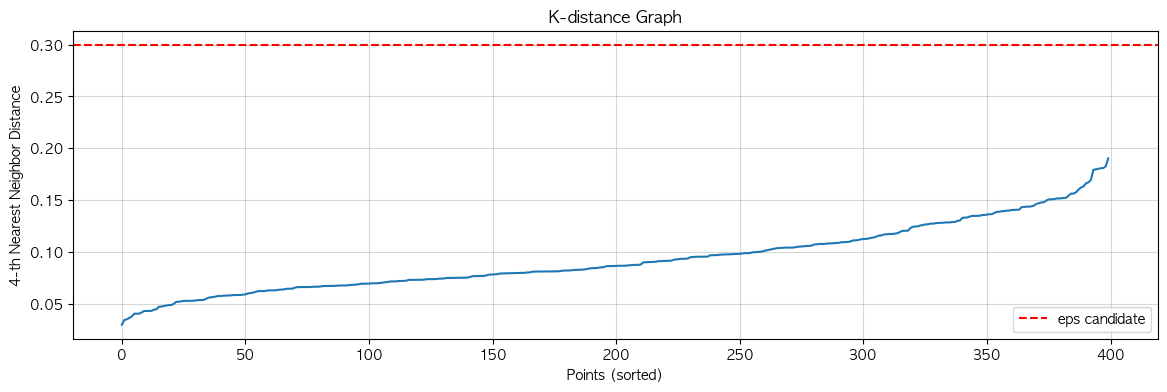

In [102]:
# 데이터 생성
X1, _ = make_moons(n_samples=200, noise=0.05, random_state=0)
X2, _ = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=0)
X2[:, 0] += 3
X = np.vstack([X1, X2])

# k-distance 그래프로 eps 찾기
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X)
distance, indices = neighbors.kneighbors(X)

# k번째 거리만 (자기 자신 제외)
k_distances = np.sort(distance[:, k-1])

plt.figure(figsize=(14, 4))
plt.plot(k_distances)
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.xlabel('Points (sorted)')
plt.title('K-distance Graph')
plt.axhline(y=0.3, color='r', linestyle='--', label='eps candidate')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

군집 수: 2개
노이즈 포인트: 0개
군집 0: 100개
군집 1: 300개


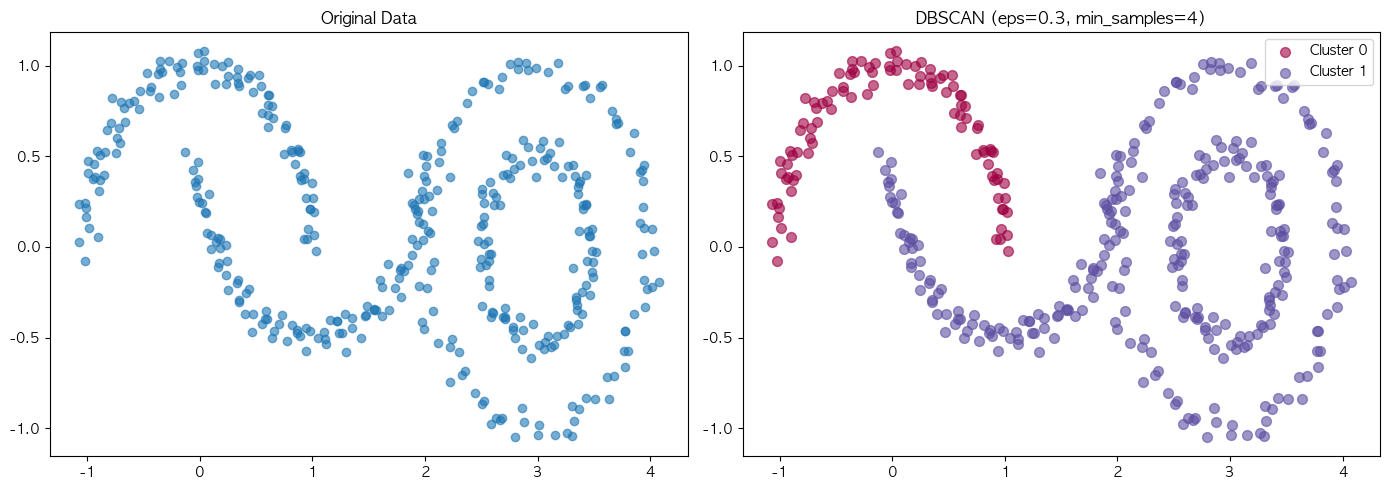

In [103]:
# DBSCAN 적용
dbscan = DBSCAN(eps=0.3, min_samples=4)
labels = dbscan.fit_predict(X)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"군집 수: {n_clusters}개")
print(f"노이즈 포인트: {n_noise}개")

# 각 군집 크기
for i in range(n_clusters):
    count = np.sum(labels == i)
    print(f"군집 {i}: {count}개")

# 시각화
plt.figure(figsize=(14, 5))

# 원본
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.title('Original Data')

# DBSCAN 결과
plt.subplot(1, 2, 2)
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
for k, col in zip(range(n_clusters), colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], alpha=0.6, 
               label=f'Cluster {k}', s=50)

# 노이즈
noise_mask = (labels == -1)
if np.any(noise_mask):
    plt.scatter(X[noise_mask, 0], X[noise_mask, 1], 
               c='black', marker='x', s=50, label='Noise')

plt.title(f'DBSCAN (eps={0.3}, min_samples={4})')
plt.legend()
plt.tight_layout()
plt.show()

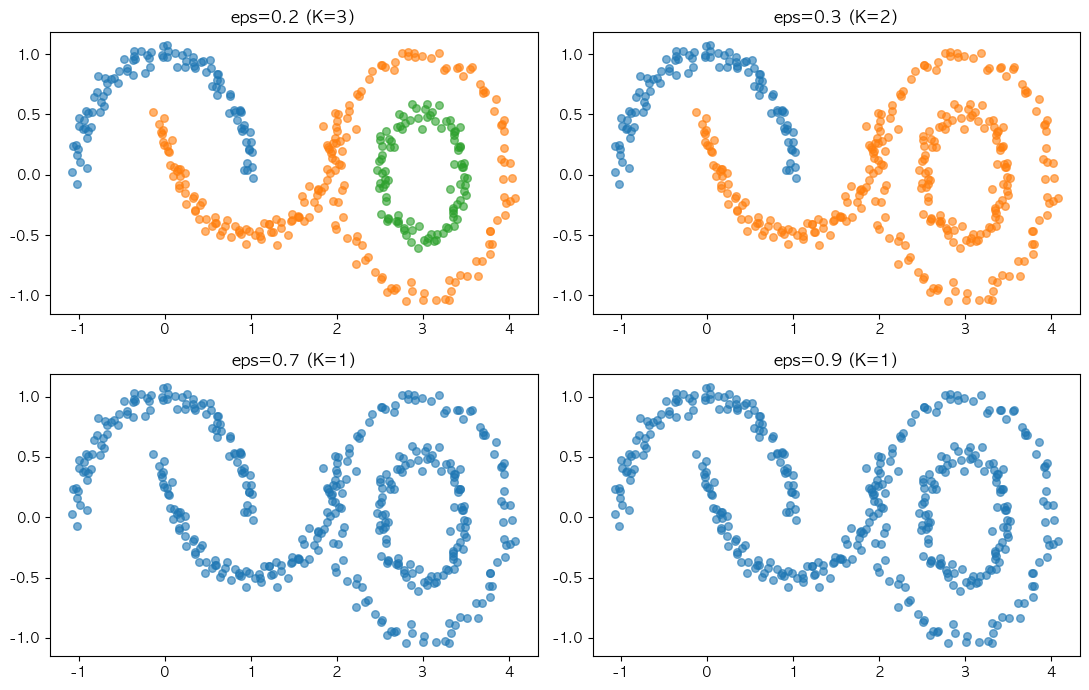

In [123]:
# 다양한 eps 비교
eps_values = [0.2, 0.3, 0.7, 0.9]
fig, axes = plt.subplots(2, 2, figsize=(11, 7))

for idx, eps in enumerate(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=4)
    labels = dbscan.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    ax = axes[idx // 2, idx % 2]
    
    # 군집 그리기
    for k in range(n_clusters):
        mask = (labels == k)
        ax.scatter(X[mask, 0], X[mask, 1], alpha=0.6, s=30)
    
    # 노이즈
    noise_mask = (labels == -1)
    if np.any(noise_mask):
        ax.scatter(X[noise_mask, 0], X[noise_mask, 1], 
                  c='black', marker='x', s=30)
    
    ax.set_title(f'eps={eps} (K={n_clusters})')

plt.tight_layout()
plt.show()